In [ ]:
# ============================================
# 📦 Part 1: Setup and Imports
# ============================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Core imports
import numpy as np
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


Mounted at /content/drive


In [ ]:
# ============================================
# 📁 Part 2: Dataset Paths and Preprocessing
# ============================================

# Dataset directories (updated to Google Drive)
train_dir = pathlib.Path('/content/drive/MyDrive/brain_tumor_dataset/Training')
val_dir   = pathlib.Path('/content/drive/MyDrive/brain_tumor_dataset/Testing')

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1303 images belonging to 4 classes.


In [ ]:
# ============================================
# 🧠 Part 3: Model Definition
# ============================================

# ============================================
# # 🧠 Part 3: Model Definition (Modified)
# ============================================

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # === MODIFICATION: Add a 'name' to the layer you want to visualize ===
    layers.Conv2D(128, (3, 3), activation='relu', name='last_conv_layer'),
    # ===================================================================

    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================
# ⚙️ Part 4: Compile and Train the Model
# ============================================

lr = 1e-4

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4479 - loss: 1.1564 - precision: 0.7079 - recall: 0.1872
Epoch 1: val_loss improved from inf to 0.96003, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1709s 10s/step - accuracy: 0.4485 - loss: 1.1556 - precision: 0.7081 - recall: 0.1879 - val_accuracy: 0.6623 - val_loss: 0.9600 - val_precision: 0.7165 - val_recall: 0.5702 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7014 - loss: 0.7364 - precision: 0.7771 - recall: 0.5937
Epoch 2: val_loss improved from 0.96003 to 0.70572, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 520ms/step - accuracy: 0.7015 - loss: 0.7363 - precision: 0.7772 - recall: 0.5939 - val_accuracy: 0.7536 - val_loss: 0.7057 - val_precision: 0.7951 - val_recall: 0.6938 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7534 - loss: 0.6456 - precision: 0.8032 - recall: 0.6756
Ep

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7737 - loss: 0.5711 - precision: 0.7898 - recall: 0.7623
Validation Accuracy: 0.8028
Validation Precision: 0.8218
Validation Recall: 0.7928


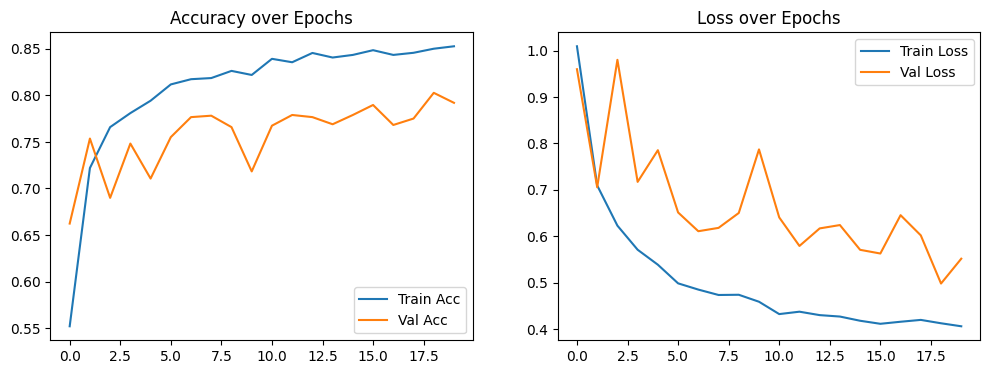

In [ ]:
# ============================================
# 📊 Part 5: Evaluation and Visualization
# ============================================

# Evaluate model
val_loss, val_acc, val_precision, val_recall = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()


In [ ]:
# ===========================================
# # 💾 Part 6: Save the Final Model
# ===========================================

# Define a path to save the model (e.g., in your Google Drive)
save_path = '/content/drive/MyDrive/swin_gpu_results/my_final_model.keras'

# Save the model
model.save(save_path)

print(f"Model successfully saved to {save_path}")

Model successfully saved to /content/drive/MyDrive/swin_gpu_results/my_final_model.keras


In [ ]:
# ✅ Identify if model has nested Sequential
for layer in model.layers:
    print(layer.name, type(layer))

# ✅ If an inner Sequential exists, use it
if isinstance(model.layers[0], tf.keras.Sequential):
    print("⚙️ Switching to inner Sequential model for Grad-CAM...")
    inner_model = model.layers[0]
    dummy_input = tf.zeros((1, 224, 224, 3))
    _ = inner_model(dummy_input)
    model = inner_model  # use inner model from now


conv2d_3 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
max_pooling2d_3 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
conv2d_4 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
max_pooling2d_4 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
last_conv_layer <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
max_pooling2d_5 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
flatten_1 <class 'keras.src.layers.reshaping.flatten.Flatten'>
dense_2 <class 'keras.src.layers.core.dense.Dense'>
dropout_1 <class 'keras.src.layers.regularization.dropout.Dropout'>
dense_3 <class 'keras.src.layers.core.dense.Dense'>


In [ ]:
gradcam_heatmaps, processed_images = getHeatMap(images, labels, model, CONV_LAYER_NAME)

In [ ]:
# ============================================
# # 🔍 Part 6: Grad-CAM and Grad-CAM++ Functions
# ============================================

import cv2
from keras import backend as K

# Define the name of the layer to visualize
CONV_LAYER_NAME = 'last_conv_layer'

def gradCam(image_batch, true_label_batch, model, layer_conv_name):
    """
    Adapted from the gradCam function in the PDF [cite: 383-401].
    It explains the model's decision based on the *true label*.
    """
    # Ensure the model has been built by calling it on the input batch
    _ = model(image_batch)

    # Create a model that outputs the conv layer and final prediction
    model_grad = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_conv_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image_batch)

        # Calculate loss based on the true label
        # This matches the PDF's intent [cite: 393]
        loss = tf.keras.losses.categorical_crossentropy(true_label_batch, predictions)

        tape.watch(conv_output)
        # Get gradients
        grad = tape.gradient(loss, conv_output)

    # Global Average Pooling of the gradients (as in PDF [cite: 395])
    grad_weights = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))

    conv_output = np.squeeze(conv_output.numpy())

    # Weight the feature maps by the gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad_weights[i] # [cite: 397]

    # Create heatmap
    heatmap = tf.reduce_mean(conv_output, axis=-1) # [cite: 398]
    heatmap = np.maximum(heatmap, 0) # ReLU [cite: 399]
    heatmap /= tf.reduce_max(heatmap) # Normalize [cite: 400]
    heatmap = cv2.resize(heatmap, (image_batch.shape[2], image_batch.shape[1])) # Resize [cite: 401]

    return np.squeeze(heatmap), np.squeeze(image_batch)

def grad_cam_plus_plus(image_batch, model, conv_layer_name):
    """
    Adapted from the grad_cam_plus_plus function in the PDF [cite: 414-436].
    The PDF's code is contradictory. This implementation follows the
    parts that are functional, which explain the model's decision
    based on the *predicted label* (argmax)[cite: 421, 425, 426].
    """
    # Ensure the model has been built by calling it on the input batch
    _ = model(image_batch)

    gradModel = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = gradModel(image_batch)
        tape.watch(conv_output)

        # Get score for the *predicted* class [cite: 421]
        score = predictions[:, np.argmax(predictions[0])]

        # Get gradients [cite: 425]
        grads = tape.gradient(score, conv_output)

    # This is the weighting step from the PDF [cite: 426]
    # (The other complex calculations in the PDF [cite: 427-431] are non-functional)
    grad_weights = tf.reduce_mean(tf.abs(grads), axis=(0, 1, 2))

    conv_output = np.squeeze(conv_output.numpy())

    # Weight the feature maps
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] = conv_output[:, :, i] * grad_weights[i] # [cite: 433]

    # Create heatmap
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap) # [cite: 434]
    heatmap = cv2.resize(heatmap, (image_batch.shape[2], image_batch.shape[1])) # [cite: 435]
    return heatmap

In [ ]:
# ✅ Force the model to build (initialize shapes)
_ = model(images[:1])  # Pass one image through it

# ✅ Now print all layers safely
for i, layer in enumerate(model.layers):
    print(i, layer.name, getattr(layer, 'output_shape', 'No shape yet'))


0 conv2d_3 No shape yet
1 max_pooling2d_3 No shape yet
2 conv2d_4 No shape yet
3 max_pooling2d_4 No shape yet
4 last_conv_layer No shape yet
5 max_pooling2d_5 No shape yet
6 flatten_1 No shape yet
7 dense_2 No shape yet
8 dropout_1 No shape yet
9 dense_3 No shape yet


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


0 conv2d_3 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
1 max_pooling2d_3 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
2 conv2d_4 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
3 max_pooling2d_4 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
4 last_conv_layer <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
5 max_pooling2d_5 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
6 flatten_1 <class 'keras.src.layers.reshaping.flatten.Flatten'>
7 dense_2 <class 'keras.src.layers.core.dense.Dense'>
8 dropout_1 <class 'keras.src.layers.regularization.dropout.Dropout'>
9 dense_3 <class 'keras.src.layers.core.dense.Dense'>
